In [1]:
import os
import json
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

from model_googlenet import GoogLeNet

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
def predict(img_addr):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    data_transform = transforms.Compose(
        [transforms.Resize((224, 224)),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    # read class_indict
    json_path = './class_indices.json'
    assert os.path.exists(json_path), "file: '{}' dose not exist.".format(json_path)

    json_file = open(json_path, "r")
    class_indict = json.load(json_file)

    # create model
    model = GoogLeNet(num_classes=5, if_aux_logits=True, if_init_weights=False).to(device)

    # load model weights
    weights_path = "./googleNet.pth"
    assert os.path.exists(weights_path), "file: '{}' dose not exist.".format(weights_path)
    missing_keys, unexpected_keys = model.load_state_dict(torch.load(weights_path, map_location=device),
                                                          strict=False)

    model.eval()
    
    # load a to-be-predicted flower image
    img_to_show = Image.open(img_addr)
#     plt.imshow(img)
    # [N, C, H, W]
    img = data_transform(img_to_show)
    # expand batch dimension
    img = torch.unsqueeze(img, dim=0)

    with torch.no_grad():
        # predict class
        output = torch.squeeze(model(img.to(device))[0]).cpu()
        predict = torch.softmax(output, dim=0)
        predict_cla = torch.argmax(predict).numpy()

    print_res = "{}  class: {}   prob: {:.3}".format(img_name, class_indict[str(predict_cla)],
                                                 predict[predict_cla].numpy())
    return img_to_show, print_res

test_01.jpg  class: dandelion   prob: 0.511
test_02.jpg  class: tulips   prob: 0.936
test_03.jpg  class: daisy   prob: 0.629
test_04.jpg  class: dandelion   prob: 0.946
test_05.jpg  class: sunflowers   prob: 0.852
test_06.jpg  class: dandelion   prob: 0.948
test_07.jpg  class: tulips   prob: 0.823
test_08.jpg  class: daisy   prob: 0.727
test_09.jpg  class: tulips   prob: 0.494
test_10.jpg  class: daisy   prob: 0.822
test_11.jpg  class: dandelion   prob: 0.772
test_12.jpg  class: tulips   prob: 0.714
test_13.jpg  class: tulips   prob: 0.892
test_14.jpg  class: tulips   prob: 0.969
test_15.jpg  class: daisy   prob: 0.971
test_16.jpg  class: tulips   prob: 0.773
test_17.jpg  class: sunflowers   prob: 0.999
test_18.jpg  class: dandelion   prob: 0.577
test_19.jpg  class: roses   prob: 0.448
test_20.jpg  class: roses   prob: 0.678


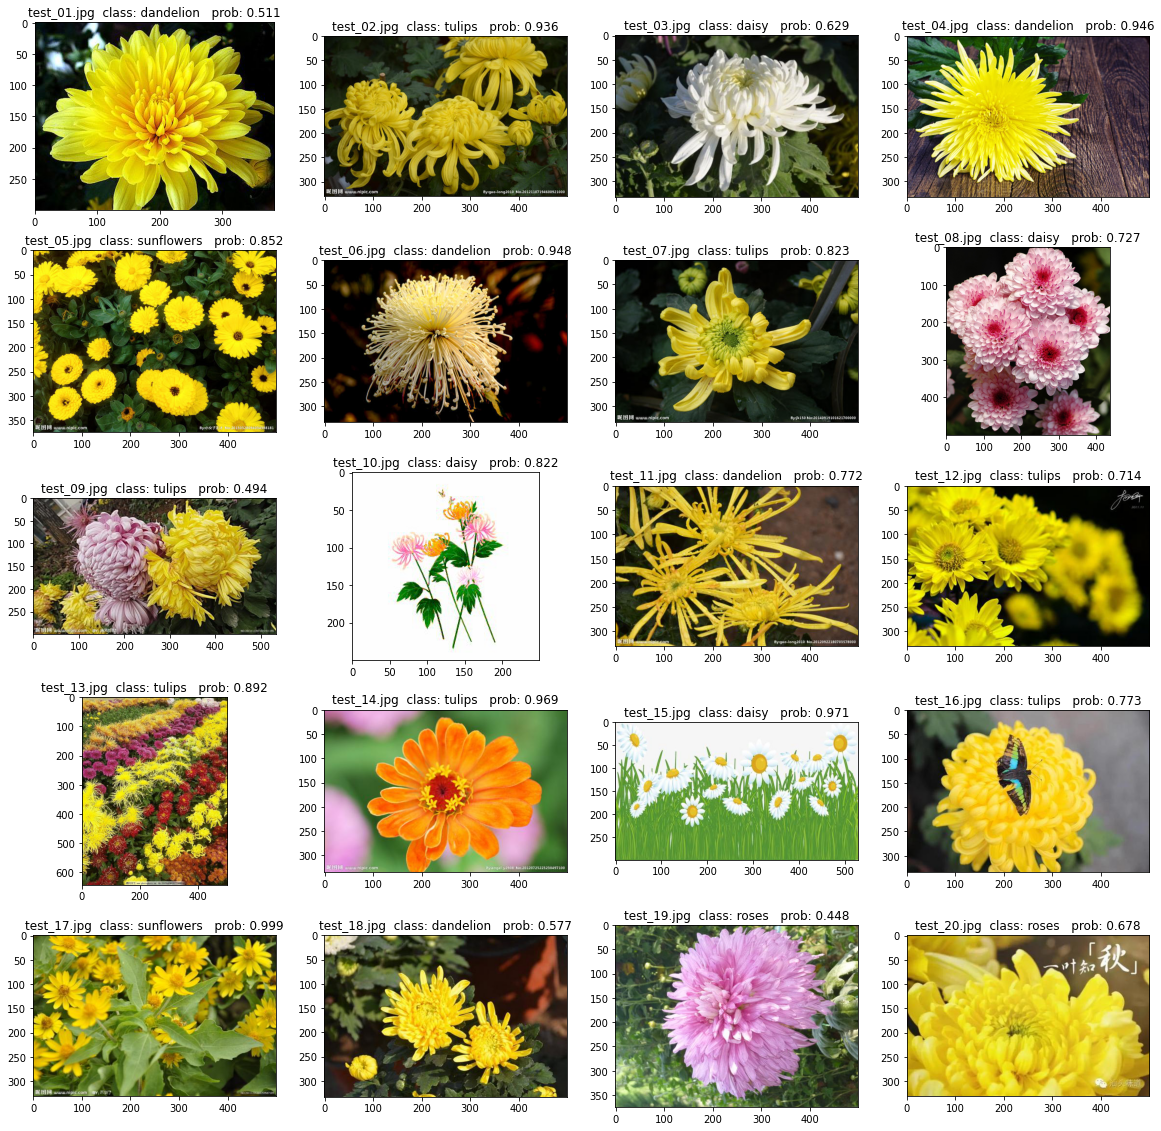

CPU times: user 9.88 s, sys: 1.39 s, total: 11.3 s
Wall time: 7.81 s


In [3]:
%%time

img_path = os.path.join(os.getcwd(), "test_data")  #you may test on your own test set
num_imgs = len(os.listdir(img_path)) - 1  # -1 because there is usually a .ipynb checkpoint file in the img_path
plt.figure(figsize=(20, 20))

for i in range(1, num_imgs+1):
    img_name = "test_{}.jpg".format(str(i) if i >= 10 else str(0)+str(i))
    img_addr = os.path.join(img_path, img_name)
#     print(img_addr)
    try:
        assert os.path.exists(img_addr)
    except:
        print("img {} dose not exist.".format(img_addr))
        continue
    img_to_show, print_res = predict(img_addr)
    print(print_res)
    plt.subplot((num_imgs-1)//4 + 1, 4, i)
    plt.title(print_res)
    plt.imshow(img_to_show)
plt.show()